<a href="https://colab.research.google.com/github/JavierCarrillo12/Computacion-visual-jtorresle-jugomezra-dagarzonmo-jacarrillo/blob/main/Talleres/2025-06-13_taller_yolo_sam/yolo_sam_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics segment-anything opencv-python matplotlib pandas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

  Preparing metadata (setup.py) ... done


In [3]:
# Constante HOME para facilitar manejo de archivos.
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [4]:
!mkdir -p {HOME}/weights # crea carpeta weights.
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights # descarga el archivo de preentrenamiento de SAM y lo guarda en weights

In [5]:

import os
#guarda/establece la ruta del archivo de pre entreno en weights.
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

# imprime la ruta donde quedo el archivo de pre entrenamiento.
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True



0: 384x640 5 persons, 1 bottle, 23.6ms
Speed: 2.6ms preprocess, 23.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


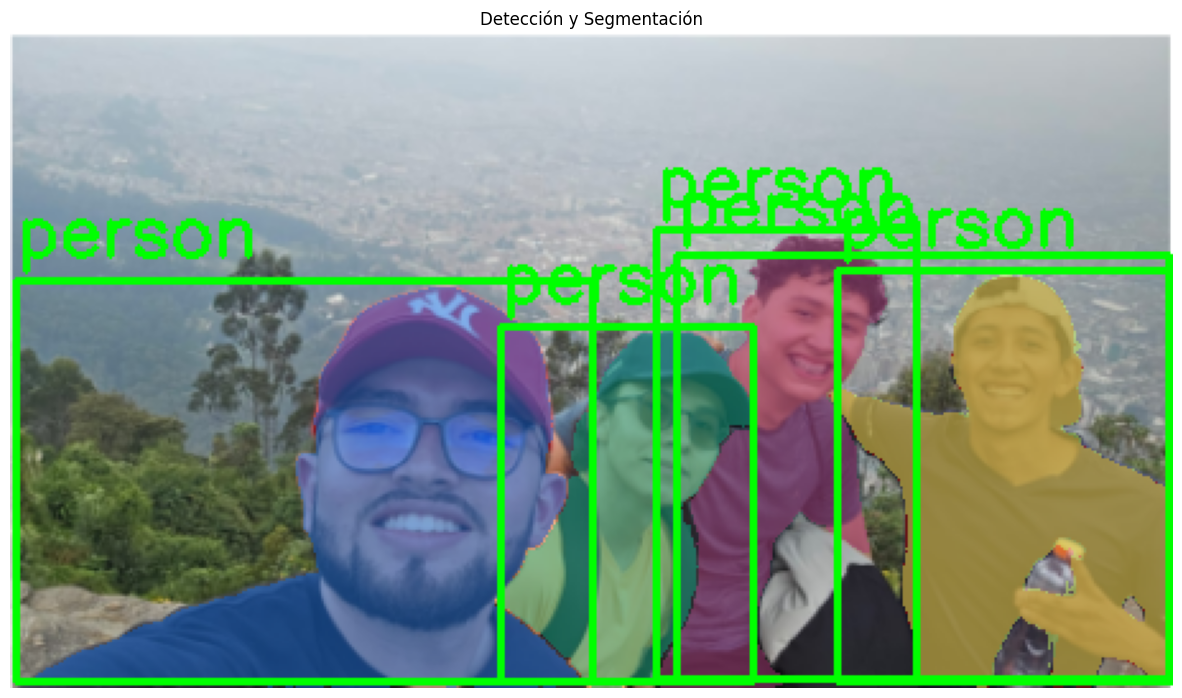

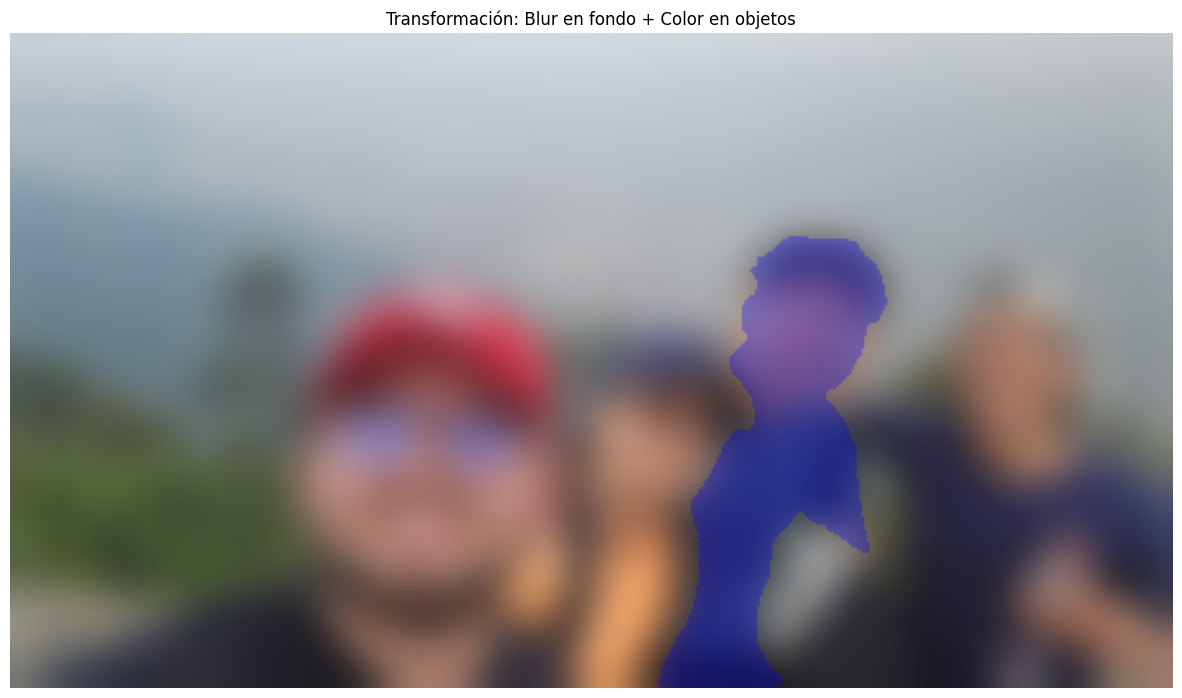


Resumen de análisis:
   object_id   class  area_pixels  area_percentage  num_contours  contour_area
0          1  person        16248        13.864428             1       15918.0
1          2  person        11970        10.214008             1       12089.0
2          3  person         7479         6.381835             1        7307.0
3          4  person        12146        10.364189             2           0.0
4          5  person         7639         6.518363             1        7396.5


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
import pandas as pd
import torch

class ObjectSegmenter:
    def __init__(self, yolo_model='yolov8n.pt', sam_model='vit_h', sam_checkpoint=CHECKPOINT_PATH):
        # Cargar modelos
        self.yolo = YOLO(yolo_model)
        self.sam = sam_model_registry[sam_model](checkpoint=sam_checkpoint)
        self.predictor = SamPredictor(self.sam)
        # Usar GPU si está disponible

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.sam.to(device)

        # Configuración
        self.classes_to_detect = ['person', 'dog']  # Personalizar según necesidades

    def detect_objects_yolo(self, image_path):
        """Detección de objetos con YOLOv8"""
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found or could not be loaded from {image_path}")
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Ejecutar detección
        results = self.yolo(image_rgb)

        # Extraer bounding boxes y clases
        boxes = []
        classes = []
        confidences = []

        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                cls_name = result.names[cls_id]

                if cls_name in self.classes_to_detect:
                    # Convertir a formato SAM (xyxy)
                    bbox = box.xyxy[0].tolist()
                    boxes.append(bbox)
                    classes.append(cls_name)
                    confidences.append(float(box.conf[0]))

        return image_rgb, boxes, classes, confidences

    def segment_with_sam(self, image, boxes):
        """Segmentación de objetos usando SAM con las cajas de YOLO como prompts"""
        self.predictor.set_image(image)

        all_masks = []
        if boxes:
            for box in boxes:
                # Convert single box to numpy array with shape (1, 4)
                sam_box = np.array(box)[None, :]

                # Obtain masks for the single box
                masks, _, _ = self.predictor.predict(
                    box=sam_box,
                    multimask_output=False  # One mask per object
                )
                if masks is not None and len(masks) > 0:
                    # SAM can return multiple masks even with multimask_output=False,
                    # although typically only one high-quality mask is expected for a box prompt.
                    # We will take the first mask returned for each box.
                    all_masks.append(masks[0])


        return np.array(all_masks) if all_masks else np.zeros((0, image.shape[0], image.shape[1]), dtype=bool)


    def visualize_results(self, image, boxes, masks, classes):
        """Visualización de resultados con cajas y máscaras"""
        # Crear copia para visualización
        vis_image = image.copy()

        # Draw masks
        if masks is not None and len(masks) > 0:
            for mask in masks:
                color = np.random.randint(0, 256, size=3).tolist()
                vis_image = np.where(
                    mask[..., None],
                    vis_image * 0.5 + np.array(color) * 0.5,
                    vis_image
                ).astype(np.uint8)

        # Dibujar bounding boxes
        for box, cls in zip(boxes, classes):
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(vis_image, cls, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Mostrar resultados
        plt.figure(figsize=(15, 10))
        plt.imshow(vis_image)
        plt.axis('off')
        plt.title('Detección y Segmentación')
        plt.show()

        return vis_image

    def apply_transformations(self, image, masks):
        """Aplicar transformaciones creativas a la imagen"""
        # Versión con blur en todo excepto objetos segmentados
        blurred_bg = cv2.GaussianBlur(image, (51, 51), 0)
        transformed = image.copy()

        if masks is not None and len(masks) > 0:
            for mask in masks:
                # Crear máscara invertida (fondo)
                inverse_mask = np.logical_not(mask)

                # Apply blur to the background using the inverse mask
                # Need to ensure dimensions match. The inverse_mask is 2D (H, W),
                # blurred_bg and transformed are 3D (H, W, C).
                # We can apply the mask to each channel.
                for c in range(transformed.shape[2]):
                    transformed[:, :, c][inverse_mask] = blurred_bg[:, :, c][inverse_mask]


                # Opcional: Cambiar color de los objetos
                for c in range(transformed.shape[2]):
                    transformed[:, :, c][mask] = transformed[:, :, c][mask] * 0.7 + np.array([0, 0, 255])[c] * 0.3


        plt.figure(figsize=(15, 10))
        plt.imshow(transformed)
        plt.axis('off')
        plt.title('Transformación: Blur en fondo + Color en objetos')
        plt.show()

        return transformed


    def analyze_segmentations(self, masks, classes, image_size, image):
        """Análisis de segmentaciones y generación de reporte"""
        data = []
        total_pixels = image_size[0] * image_size[1]

        if masks is not None and len(masks) > 0:
            # Ensure the number of masks matches the number of classes
            if len(masks) != len(classes):
                 print(f"Warning: Number of masks ({len(masks)}) does not match number of classes ({len(classes)}). Analysis might be inaccurate.")


            for i, (mask, cls) in enumerate(zip(masks, classes)):
                # Calcular área
                area_pixels = np.sum(mask)
                area_percentage = (area_pixels / total_pixels) * 100

                # Encontrar contornos
                # Ensure mask is boolean and has the correct shape (H, W)
                if mask.ndim == 3: # Handle case where mask might have a channel dimension
                    mask_single_channel = mask[:, :, 0]
                else:
                    mask_single_channel = mask

                mask_uint8 = mask_single_channel.astype(np.uint8) * 255

                contours, _ = cv2.findContours(
                    mask_uint8,
                    cv2.RETR_EXTERNAL,
                    cv2.CHAIN_APPROX_SIMPLE
                )

                # Guardar datos
                data.append({
                    'object_id': i + 1,
                    'class': cls,
                    'area_pixels': area_pixels,
                    'area_percentage': area_percentage,
                    'num_contours': len(contours),
                    'contour_area': cv2.contourArea(contours[0]) if contours else 0
                })

                # Guardar recorte del objeto con fondo blanco
                # Ensure mask is boolean and has the correct shape for indexing
                if mask.ndim == 3:
                     mask_bool = mask[:, :, 0].astype(bool)
                else:
                    mask_bool = mask.astype(bool)

                object_crop = np.ones_like(image) * 255
                object_crop[mask_bool] = image[mask_bool]
                plt.imsave(f'object_{i+1}_{cls}.png', object_crop)


        # Crear y guardar DataFrame
        df = pd.DataFrame(data)
        df.to_csv('segmentation_analysis.csv', index=False)

        return df

    def process_image(self, image_path):
        """Pipeline completo de procesamiento"""
        # Paso 1: Detección con YOLO
        image, boxes, classes, confs = self.detect_objects_yolo(image_path)

        # Paso 2: Segmentación con SAM
        masks = self.segment_with_sam(image, boxes)

        # Paso 3: Visualización
        vis_image = self.visualize_results(image, boxes, masks, classes)

        # Paso 4: Transformaciones creativas
        transformed = self.apply_transformations(image, masks)

        # Paso 5: Análisis y reporte
        analysis_df = self.analyze_segmentations(masks, classes, image.shape[:2], image)

        return vis_image, transformed, analysis_df


# Uso del pipeline
if __name__ == "__main__":
    segmenter = ObjectSegmenter()
    image_path = "/content/MONSERRATE.png"  # Reemplazar con tu ruta de imagen

    # Ejecutar todo el proceso
    vis_img, transformed_img, analysis = segmenter.process_image(image_path)

    # Mostrar análisis
    print("\nResumen de análisis:")
    print(analysis)

## Summary:

### Data Analysis Key Findings

*   The `boxes` variable returned by the YOLO model is a Python list, where each element is a list of four floating-point numbers representing a bounding box in `[x1, y1, x2, y2]` format.
*   The `SamPredictor.predict` method expects the `box` input to be a `np.ndarray` representing a single batch of boxes. When providing multiple boxes, the expected shape is `(N, 4)`, where N is the number of boxes. The original error `RuntimeError: The size of tensor a (4) must match the size of tensor b (256) at non-singleton dimension 3` indicated a mismatch in how the batched box embeddings were being processed internally by SAM when given the incorrect input shape.
*   Passing the entire list of boxes converted directly to a NumPy array `np.array(boxes)` to `SamPredictor.predict` resulted in dimension errors because `predict` expects a batched input where each item in the batch is a prompt (like a single box), not a single batch item containing *all* boxes.
*   The fix involved iterating through each individual box detected by YOLO and calling `SamPredictor.predict` for each box separately. Each individual box was converted to a NumPy array of shape `(1, 4)` before being passed to `predict`, correctly simulating a batch of size 1 for each prediction call. The resulting masks from each call were then collected.

### Insights or Next Steps

*   When using SAM with multiple object detections from another model like YOLO, process each detected bounding box individually by calling `SamPredictor.predict` in a loop, ensuring each box is formatted as a `(1, 4)` NumPy array.
*   Refine the mask collection and handling logic in `segment_with_sam` to efficiently combine masks from multiple predictions into a single structure for subsequent steps.
